In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
from sklearn.metrics import mean_absolute_error,accuracy_score,mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv('../data/min_max_df.csv', parse_dates=['date'], index_col=[0])

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,98146,98148,98155,98166,98168,98177,98178,98188,98198,98199
0,7129300520,2014-10-13,0.018880,0.222222,0.066667,0.061503,0.003108,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,6414100192,2014-12-09,0.060352,0.222222,0.233333,0.167046,0.004072,0.4,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5631500400,2015-02-25,0.013382,0.111111,0.066667,0.030372,0.005743,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2487200875,2014-12-09,0.069011,0.333333,0.333333,0.120729,0.002714,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1954400510,2015-02-18,0.056678,0.222222,0.200000,0.099468,0.004579,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month

In [6]:
ohe = pd.get_dummies(df.year, sparse=False)
df = df.join(ohe)

In [7]:
ohe = pd.get_dummies(df.month, sparse=False)
df = df.join(ohe)

In [8]:
df.columns

Index([         'id',        'date',       'price',    'bedrooms',
         'bathrooms', 'sqft_living',    'sqft_lot',      'floors',
        'waterfront',        'view',
       ...
                   3,             4,             5,             6,
                   7,             8,             9,            10,
                  11,            12],
      dtype='object', length=115)

In [9]:
full_feats = ['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'renovated', 'since_reno',
       'has_basement', 'basement_lot_pct', 'aboveground_lot_pct', 'PctofLot',
       'age', 'likelyApartment', '98001', '98002', '98003', '98004', '98005',
       '98006', '98007', '98008', '98010', '98011', '98014', '98019', '98022',
       '98023', '98024', '98027', '98028', '98029', '98030', '98031', '98032',
       '98033', '98034', '98038', '98039', '98040', '98042', '98045', '98052',
       '98053', '98055', '98056', '98058', '98059', '98065', '98070', '98072',
       '98074', '98075', '98077', '98092', '98102', '98103', '98105', '98106',
       '98107', '98108', '98109', '98112', '98115', '98116', '98117', '98118',
       '98119', '98122', '98125', '98126', '98133', '98136', '98144', '98146',
       '98148', '98155', '98166', '98168', '98177', '98178', '98188', '98198',
       '98199']

In [10]:
X = df[full_feats]
y = df.price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [11]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [31]:
keras.backend.clear_session()

In [32]:
early_stopping = EarlyStopping(
    min_delta=0.001, 
    patience=20, 
    restore_best_weights=True,
)

kerasModel = keras.Sequential([
    layers.Dense(32, activation='sigmoid', input_shape=[X_train.shape[1],], kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    #layers.Dropout(.2),
    layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    #layers.Dropout(.5),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(.5),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    #layers.Dropout(.5),
    layers.Dense(1)
])
    

In [33]:
optimizer = keras.optimizers.Adam(lr=0.0005)  #could try .0005 to train longer

kerasModel.compile(
    optimizer=optimizer,
    loss='mean_absolute_error',
    metrics=['mean_absolute_error'],
)

history = kerasModel.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=64,
    epochs=100,
    verbose=1,
)

Epoch 1/100
270/270 [==============================] - 4s 8ms/step - loss: 1.3139 - mean_absolute_error: 1.2424 - val_loss: 0.1362 - val_mean_absolute_error: 0.0640
Epoch 2/100
270/270 [==============================] - 2s 9ms/step - loss: 0.6180 - mean_absolute_error: 0.5457 - val_loss: 0.1510 - val_mean_absolute_error: 0.0788
Epoch 3/100
270/270 [==============================] - 2s 7ms/step - loss: 0.1693 - mean_absolute_error: 0.0973 - val_loss: 0.1030 - val_mean_absolute_error: 0.0316
Epoch 4/100
270/270 [==============================] - 2s 7ms/step - loss: 0.1277 - mean_absolute_error: 0.0564 - val_loss: 0.1009 - val_mean_absolute_error: 0.0302
Epoch 5/100
270/270 [==============================] - 2s 7ms/step - loss: 0.1250 - mean_absolute_error: 0.0546 - val_loss: 0.1013 - val_mean_absolute_error: 0.0316
Epoch 6/100
270/270 [==============================] - 2s 8ms/step - loss: 0.1262 - mean_absolute_error: 0.0568 - val_loss: 0.0975 - val_mean_absolute_error: 0.0288
Epoch 7/10

270/270 [==============================] - 2s 8ms/step - loss: 0.0523 - mean_absolute_error: 0.0390 - val_loss: 0.0322 - val_mean_absolute_error: 0.0191
Epoch 51/100
270/270 [==============================] - 2s 8ms/step - loss: 0.0503 - mean_absolute_error: 0.0373 - val_loss: 0.0254 - val_mean_absolute_error: 0.0126
Epoch 52/100
270/270 [==============================] - 2s 8ms/step - loss: 0.0514 - mean_absolute_error: 0.0385 - val_loss: 0.0255 - val_mean_absolute_error: 0.0128
Epoch 53/100
270/270 [==============================] - 3s 11ms/step - loss: 0.0484 - mean_absolute_error: 0.0356 - val_loss: 0.0718 - val_mean_absolute_error: 0.0593
Epoch 54/100
270/270 [==============================] - 2s 8ms/step - loss: 0.0500 - mean_absolute_error: 0.0376 - val_loss: 0.0253 - val_mean_absolute_error: 0.0131
Epoch 55/100
270/270 [==============================] - 3s 9ms/step - loss: 0.0477 - mean_absolute_error: 0.0355 - val_loss: 0.0395 - val_mean_absolute_error: 0.0274
Epoch 56/100
270

270/270 [==============================] - 2s 9ms/step - loss: 0.0397 - mean_absolute_error: 0.0292 - val_loss: 0.0328 - val_mean_absolute_error: 0.0227
Epoch 100/100
270/270 [==============================] - 2s 9ms/step - loss: 0.0388 - mean_absolute_error: 0.0288 - val_loss: 0.0221 - val_mean_absolute_error: 0.0123


Minimum Validation Loss: 0.0094


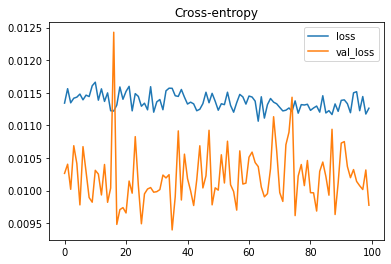

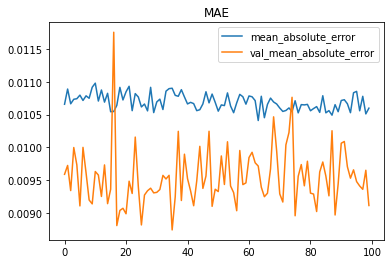

In [30]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['mean_absolute_error', 'val_mean_absolute_error']].plot(title="MAE")
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()))

In [16]:
#kerasModel.save('DeepModel1')

In [17]:
#kerasModel = keras.models.load_model('DeepModel1')

In [18]:
preds =kerasModel.predict(X)

In [19]:
resid = pd.DataFrame()
resid['target'] = df.price

In [20]:
resid['preds'] = preds
resid['resid'] = resid.target - resid.preds

In [21]:
resid.resid.mean()

0.0058760286047265095

In [22]:
resid.to_csv('KerasPreds')